In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skimage.segmentation import slic
import scipy.ndimage
import scipy.spatial
import torch
from torchvision import datasets
from torchvision import datasets
import sys
sys.path.append("../")
from chebygin import ChebyGIN
from extract_superpixels import process_image
from graphdata import comput_adjacency_matrix_images
from train_test import load_save_noise
from utils import list_to_torch, data_to_device, normalize_zero_one
import imageio
import cv2

In [2]:
data_dir = '../data'
checkpoints_dir = '../checkpoints'
device = 'cuda'

# Load images using standard PyTorch Dataset
data = datasets.MNIST(data_dir, train=False, download=True)
images = data.test_data.numpy()
targets = data.test_labels
# mean and std computed for superpixel features
# features are 3 pixel intensities and 2 coordinates (x,y)
# 3 pixel intensities because we replicate mean pixel value 3 times to test on colored MNIST images
mn = torch.tensor([0.11225057, 0.11225057, 0.11225057, 0.44206527, 0.43950436]).view(1, 1, -1)
sd = torch.tensor([0.2721889,  0.2721889,  0.2721889,  0.2987583,  0.30080357]).view(1, 1, -1)

class SuperpixelArgs():
    def __init__(self):
        self.n_sp = 75
        self.compactness = 0.25
        self.split = 'test'
        self.dataset = 'mnist'

img_size = images.shape[1]
noises = load_save_noise('../data/mnist_75sp_noise.pt', (images.shape[0], -1))
color_noises = load_save_noise('../data/mnist_75sp_color_noise.pt', (images.shape[0], -1, 3))
n_images = 100

#noise_levels = np.array([0.4, 0.6])

loading noise from ../data/mnist_75sp_noise.pt
loading noise from ../data/mnist_75sp_color_noise.pt


In [22]:
def acc(pred):
    return torch.mean((torch.stack(pred) == targets[:len(pred)]).float()).item() * 100

# This function takes a single 28x28 MNIST image, model object, and std of noise added to node features,
# performs all necessary preprocessing (including superpixels extraction) and returns predictions
def test(model, img, index, noise_std, colornoise_std, args, show_img=False):
    
    sp_intensity, sp_coord, sp_order, superpixels = process_image((img, 0, 0, SuperpixelArgs(), False, False))
    #assert np.
    if show_img:
        sz = img.shape
        plt.figure(figsize=(20,5))
        plt.subplot(141)        
        plt.imshow(img / 255., cmap='gray')
        plt.title('Input MNIST image')
        img_sp = np.zeros((sz[0], sz[1]))
        img_noise = np.zeros((sz[0], sz[1], 3))
        img_color_noise = np.zeros((sz[0], sz[1], 3))    
        for sp_intens, sp_index in zip(sp_intensity, sp_order):
            mask = superpixels == sp_index
            x = (sp_intens - mn[0, 0, 0].item()) / sd[0, 0, 0].item()
            img_sp[mask] = x
            img_noise[mask] = x + noises[index, sp_index] * noise_std
            img_color_noise[mask] = x + color_noises[index, sp_index] * colornoise_std
        plt.subplot(142)
        plt.imshow(normalize_zero_one(img_sp), cmap='gray')
        plt.title('Superpixels of the image')
        plt.subplot(143)
        plt.imshow(normalize_zero_one(img_noise), cmap='gray')
        plt.title('Noisy superpixels')
        plt.subplot(144)
        plt.imshow(normalize_zero_one(img_color_noise))
        plt.title('Noisy and colored superpixels')
        plt.show()
            
    sp_coord = sp_coord / img_size
    N_nodes = sp_intensity.shape[0]
    mask = torch.ones(1, N_nodes, dtype=torch.uint8)
    x = (torch.from_numpy(np.pad(np.concatenate((sp_intensity, sp_coord), axis=1), 
                                ((0, 0), (2, 0)), 'edge')).unsqueeze(0) - mn) / sd    
    A = torch.from_numpy(comput_adjacency_matrix_images(sp_coord)).float().unsqueeze(0)
    y, other_outputs = model(data_to_device([x, A, mask, -1, {'N_nodes': torch.zeros(1, 1) + N_nodes}], 
                                            device))
    y_clean = torch.argmax(y).data.cpu()    
    alpha_clean = other_outputs['alpha'][0].data.cpu() if 'alpha' in other_outputs else []
    
    x_noise = x.clone()
    x_noise[:, :, :3] += noises[index, :N_nodes].unsqueeze(0).unsqueeze(2) * noise_std
    y, other_outputs = model(data_to_device([x_noise, A, mask, -1, {'N_nodes': torch.zeros(1, 1) + N_nodes}], 
                                            device))
    y_noise = torch.argmax(y).data.cpu()
    alpha_noise = other_outputs['alpha'][0].data.cpu() if 'alpha' in other_outputs else []
    x_noise = x.clone()
    x_noise[:, :, :3] += color_noises[index, :N_nodes] * colornoise_std
    y, other_outputs = model(data_to_device([x_noise, A, mask, -1, {'N_nodes': torch.zeros(1, 1) + N_nodes}], 
                                            device))
    y_colornoise = torch.argmax(y).data.cpu()
    alpha_color_noise = other_outputs['alpha'][0].data.cpu() if 'alpha' in other_outputs else []
    return y_clean, y_noise, y_colornoise, alpha_clean, alpha_noise, alpha_color_noise


# This function returns predictions for the entire clean and noise test sets
def get_predictions(model_path, noise_levels):
    state = torch.load(model_path)
    args = state['args']
    model = ChebyGIN(in_features=5,
                     out_features=10,
                     filters=args.filters,
                     K=args.filter_scale,
                     n_hidden=args.n_hidden,
                     aggregation=args.aggregation,
                     dropout=args.dropout,
                     readout=args.readout,
                     pool=args.pool,
                     pool_arch=args.pool_arch)
    model.load_state_dict(state['state_dict'])
    model = model.eval().to(device)
    #print(model)    

    # Get predictions
    pred, pred_noise, pred_colornoise = [], [], []
    alpha, alpha_noise, alpha_colornoise = [], [], []
    for index in range(n_images):
        y = test(model, images[index], index, noise_levels[0], noise_levels[1], index == 0)
        pred.append(y[0])
        pred_noise.append(y[1])
        pred_colornoise.append(y[2])  
        alpha.append(y[3])
        alpha_noise.append(y[4])
        alpha_colornoise.append(y[5])
        if len(pred) % 1000 == 0:
            print('{}/{}, acc clean={:.2f}%, acc noise={:.2f}%, acc color noise={:.2f}%'.format(len(pred), 
                                                                                            n_images,
                                                                                            acc(pred), 
                                                                                            acc(pred_noise), 
                                                                                            acc(pred_colornoise)))
    return pred, pred_noise, pred_colornoise, alpha, alpha_noise, alpha_colornoise

# General function to visualize attention coefficients alpha for models with attention
def visualize(alpha, alpha_noise, alpha_colornoise, 
              alpha_unsup, alpha_noise_unsup, alpha_colornoise_unsup,
              alpha_noise_sup,
              noise_levels):
    # Get ids of the first test sample for labels from 0 to 9
    ind = []
    labels_added = set()
    for i, lbl in enumerate(data.test_labels.numpy()):
        if lbl not in labels_added:
            ind.append(i)
            labels_added.add(lbl)
    ind_sorted = []
    for i in np.argsort(data.test_labels):
        if i in ind:
            ind_sorted.append(i)

    sz = data.test_data.shape

    images_sp, images_noise, images_color_noise, images_attn, images_attn_noise, images_attn_noise_color = [], [], [], [], [], []
    images_attn_noise_unsup, images_attn_noise_sup = [], []
    for i in ind_sorted:
        sp_intensity, sp_coord, sp_order, superpixels = process_image((images[i], 0, 0, SuperpixelArgs(), False, False))
        n_sp = sp_intensity.shape[0]
        noise, color_noise = noises[i, :n_sp], color_noises[i, :n_sp]    
        img = np.zeros((sz[1], sz[1], 3))
        img_noise = np.zeros((sz[1], sz[1], 3))
        img_color_noise = np.zeros((sz[1], sz[1], 3))    
        img_attn = np.zeros((sz[1], sz[1]))
        img_attn_noise = np.zeros((sz[1], sz[1]))
        img_attn_noise_color = np.zeros((sz[1], sz[1]))    
        img_attn_noise_unsup = np.zeros((sz[1], sz[1]))
        img_attn_noise_sup = np.zeros((sz[1], sz[1]))
        for sp_intens, sp_index in zip(sp_intensity, sp_order):
            mask = superpixels == sp_index
            x = (sp_intens - mn[0, 0, 0].item()) / sd[0, 0, 0].item()
            img[mask] = x
            img_noise[mask] = x + noise[sp_index] * noise_levels[0]
            img_color_noise[mask] = x + color_noise[sp_index] * noise_levels[1]

            img_attn[mask] = alpha[i][0, sp_index].item()
            img_attn_noise[mask] = alpha_noise[i][0, sp_index].item()
            img_attn_noise_color[mask] = alpha_colornoise[i][0, sp_index].item()
            
            img_attn_noise_unsup[mask] = alpha_noise_unsup[i][0, sp_index].item()
            img_attn_noise_sup[mask] = alpha_noise_sup[i][0, sp_index].item()

        images_sp.append(img)
        images_noise.append(img_noise)
        images_color_noise.append(img_color_noise)
        images_attn.append(img_attn)
        images_attn_noise.append(img_attn_noise)
        images_attn_noise_color.append(img_attn_noise_color)
        
        images_attn_noise_unsup.append(img_attn_noise_unsup)
        images_attn_noise_sup.append(img_attn_noise_sup)

    n_cols = 5
    n_rows = 2 
    
#     for fig_id, img_set in enumerate([images_sp, images_noise, images_color_noise, 
#                                       images_attn, images_attn_noise, images_attn_noise_color]):
#         fig = plt.figure(figsize=(15, 6))
#         for i in range(n_rows):
#             for j in range(n_cols):
#                 index = i*n_cols + j
#                 ax = fig.add_subplot(n_rows, n_cols, index + 1)                
#                 ax.imshow(normalize_zero_one(img_set[index]))
#                 ax.axis('off')
#         plt.subplots_adjust(hspace=0.1, wspace=0.1)
#         plt.show()
    
    sz = (4 * n_rows*28, n_cols*28, 3)
    img1 = np.zeros(sz)
    #img2 = np.zeros((n_rows*28, n_cols*28, 3))
    cmap = mpl.cm.get_cmap('viridis')
    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols + j
            img1[i*28: (i+1)*28, j*28: (j+1)*28, :] = normalize_zero_one(images_noise[index])
            img1[(i+2)*28: (i+3)*28, j*28: (j+1)*28, :] = cmap(normalize_zero_one(images_attn_noise_unsup[index]))[:, :, :3]
            img1[(i+4)*28: (i+5)*28, j*28: (j+1)*28, :] = cmap(normalize_zero_one(images_attn_noise_sup[index]))[:, :, :3]
            img1[(i+6)*28: (i+7)*28, j*28: (j+1)*28, :] = cmap(normalize_zero_one(images_attn_noise[index]))[:, :, :3]
    img1 = cv2.resize(img1, (sz[1]*4, sz[0]*4))
    plt.imshow(img1)
    plt.axis('off')
    plt.show()
    #plt.imshow(img2)
    #plt.axis('off')
    #plt.show()
    return img1#, img2

In [21]:
np.arange(0, 1.41, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4])

0.0
ChebyGINLayer torch.Size([4, 20]) tensor([0.5767, 0.5326, 0.5977, 0.4998], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.6111, 0.6269, 0.5923, 0.6089, 0.4991, 0.5428, 0.7199, 0.6433, 0.4843,
        0.6095], grad_fn=<SliceBackward>)
p values [-0.9808646   0.7856399   0.02598874  2.2282176 ]
cos_sim 0.6250213980674744
ChebyGINLayer torch.Size([512, 256]) tensor([0.5779, 0.5574, 0.5799, 0.6032, 0.5714, 0.5676, 0.5730, 0.5513, 0.5742,
        0.5930], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.5251, 0.6433, 0.5519, 0.5046], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5374, 0.6624, 0.5531, 0.4924, 0.4772, 0.5836, 0.5557, 0.5435, 0.5829,
        0.6555], grad_fn=<SliceBackward>)
p values [ 0.11278611  0.12554127 -1.81106     0.6316445 ]
cos_sim 0.06902020424604416
ChebyGINLayer torch.Size([512, 256]) tensor([0.5544, 0.5581, 0.5641, 0.5738, 0.5657, 0.5531, 0.5800, 0.5764, 0.5636,
        0.5819], grad_fn=<SliceBa

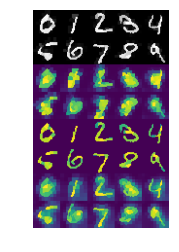

0.2
ChebyGINLayer torch.Size([4, 20]) tensor([0.5367, 0.5896, 0.5755, 0.6544], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5411, 0.5644, 0.4518, 0.6284, 0.6673, 0.6220, 0.4937, 0.5713, 0.5801,
        0.5696], grad_fn=<SliceBackward>)
p values [-0.9285858   0.92583287 -1.159137   -0.94185096]
cos_sim 0.529000997543335
ChebyGINLayer torch.Size([512, 256]) tensor([0.5957, 0.6016, 0.6027, 0.5897, 0.5332, 0.5571, 0.5608, 0.5708, 0.5945,
        0.5983], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.5407, 0.4734, 0.5952, 0.6107], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5373, 0.5270, 0.5104, 0.3918, 0.4985, 0.4583, 0.6269, 0.5618, 0.7615,
        0.5769], grad_fn=<SliceBackward>)
p values [-0.07909229 -0.3107653  -0.21366493 -1.4330431 ]
cos_sim -0.8064800500869751
ChebyGINLayer torch.Size([512, 256]) tensor([0.5678, 0.5759, 0.6053, 0.5891, 0.5861, 0.5547, 0.5689, 0.5790, 0.5864,
        0.5564], grad_fn=<SliceBac

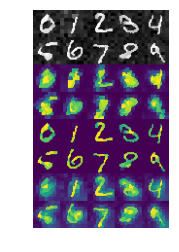

0.4
ChebyGINLayer torch.Size([4, 20]) tensor([0.5804, 0.5982, 0.6528, 0.4494], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.6337, 0.6160, 0.5997, 0.5331, 0.5713, 0.5619, 0.4708, 0.6081, 0.5530,
        0.5241], grad_fn=<SliceBackward>)
p values [0.64016104 0.68282753 1.6085074  2.372977  ]
cos_sim 0.36691248416900635
ChebyGINLayer torch.Size([512, 256]) tensor([0.6253, 0.5517, 0.5747, 0.6025, 0.5592, 0.5839, 0.5650, 0.6069, 0.5831,
        0.5756], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.5553, 0.6461, 0.5025, 0.6223], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.4790, 0.5944, 0.5182, 0.5558, 0.6965, 0.6043, 0.5877, 0.5050, 0.5689,
        0.5337], grad_fn=<SliceBackward>)
p values [ 1.0979059   0.00219263 -0.61176986  0.16624747]
cos_sim 0.0017445504199713469
ChebyGINLayer torch.Size([512, 256]) tensor([0.5791, 0.6018, 0.5754, 0.5481, 0.5860, 0.5626, 0.5823, 0.5537, 0.5653,
        0.5717], grad_fn=<SliceBac

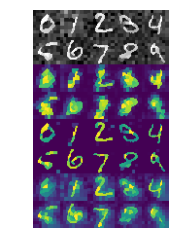

0.6000000000000001
ChebyGINLayer torch.Size([4, 20]) tensor([0.5175, 0.4560, 0.5551, 0.6992], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.6390, 0.5799, 0.5687, 0.5168, 0.4735, 0.5595, 0.5930, 0.6795, 0.5239,
        0.5752], grad_fn=<SliceBackward>)
p values [1.1736767  0.7203072  0.26012105 0.91089284]
cos_sim 0.5139780044555664
ChebyGINLayer torch.Size([512, 256]) tensor([0.6047, 0.5991, 0.6047, 0.5573, 0.5673, 0.5887, 0.5773, 0.5928, 0.5669,
        0.5851], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.5179, 0.5849, 0.6270, 0.6162], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5767, 0.5140, 0.6237, 0.6161, 0.6628, 0.6648, 0.5453, 0.5634, 0.6052,
        0.5745], grad_fn=<SliceBackward>)
p values [ 0.453077    1.2196774   0.56947803 -0.34014207]
cos_sim 0.8587580323219299
ChebyGINLayer torch.Size([512, 256]) tensor([0.5813, 0.5845, 0.5770, 0.5940, 0.5742, 0.5790, 0.6022, 0.6060, 0.5515,
        0.5881], grad_f

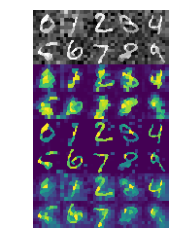

0.8
ChebyGINLayer torch.Size([4, 20]) tensor([0.5508, 0.5646, 0.5398, 0.5504], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5521, 0.5262, 0.5068, 0.5129, 0.6682, 0.5670, 0.6148, 0.5701, 0.7381,
        0.6631], grad_fn=<SliceBackward>)
p values [-0.5233727  -0.67350423  0.40664864  0.8475901 ]
cos_sim -0.7127567529678345
ChebyGINLayer torch.Size([512, 256]) tensor([0.5578, 0.5792, 0.5956, 0.5826, 0.5819, 0.5821, 0.5917, 0.5626, 0.5646,
        0.5884], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.6188, 0.6247, 0.5352, 0.5311], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5183, 0.5189, 0.6102, 0.4333, 0.5479, 0.4643, 0.6469, 0.6238, 0.5510,
        0.5720], grad_fn=<SliceBackward>)
p values [-0.99067736  0.4467075   0.06868999  0.48519048]
cos_sim 0.4102366268634796
ChebyGINLayer torch.Size([512, 256]) tensor([0.5740, 0.5849, 0.5711, 0.6074, 0.5751, 0.5997, 0.5575, 0.5884, 0.5752,
        0.5806], grad_fn=<SliceBa

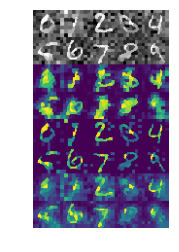

1.0
ChebyGINLayer torch.Size([4, 20]) tensor([0.6022, 0.5872, 0.4990, 0.6671], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5054, 0.5385, 0.7453, 0.5664, 0.4408, 0.6855, 0.5333, 0.6047, 0.6551,
        0.4699], grad_fn=<SliceBackward>)
p values [ 1.5297579   0.05044526 -0.75090736 -1.3479705 ]
cos_sim 0.02958899922668934
ChebyGINLayer torch.Size([512, 256]) tensor([0.5787, 0.5659, 0.5687, 0.5952, 0.5475, 0.5860, 0.6047, 0.5765, 0.5898,
        0.5599], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.5988, 0.6138, 0.5823, 0.5584], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.4495, 0.6612, 0.6734, 0.5549, 0.4325, 0.4885, 0.6279, 0.6072, 0.5678,
        0.5115], grad_fn=<SliceBackward>)
p values [ 1.0585008   0.5260047  -0.66627234 -0.47712293]
cos_sim 0.3876679837703705
ChebyGINLayer torch.Size([512, 256]) tensor([0.5527, 0.5631, 0.5699, 0.5559, 0.5671, 0.5997, 0.5853, 0.5854, 0.5567,
        0.5850], grad_fn=<SliceBa

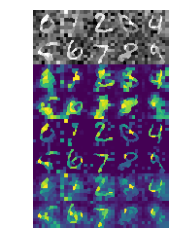

1.2000000000000002
ChebyGINLayer torch.Size([4, 20]) tensor([0.4809, 0.5934, 0.5693, 0.6049], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.6664, 0.5548, 0.5042, 0.6544, 0.5340, 0.5857, 0.6486, 0.5891, 0.6439,
        0.5316], grad_fn=<SliceBackward>)
p values [-0.6830784  -0.32267496 -0.4580633   1.3426396 ]
cos_sim -0.3652316927909851
ChebyGINLayer torch.Size([512, 256]) tensor([0.5760, 0.5748, 0.5765, 0.5665, 0.5696, 0.5763, 0.5825, 0.5944, 0.5933,
        0.5494], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.5398, 0.5421, 0.5827, 0.5710], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5477, 0.6177, 0.5949, 0.4584, 0.6498, 0.4480, 0.6559, 0.5500, 0.6957,
        0.5567], grad_fn=<SliceBackward>)
p values [-1.1363554  -1.274822    1.1665964   0.26639012]
cos_sim -0.6163941025733948
ChebyGINLayer torch.Size([512, 256]) tensor([0.5831, 0.5506, 0.5639, 0.5840, 0.5678, 0.5804, 0.5657, 0.5812, 0.5730,
        0.5816], 

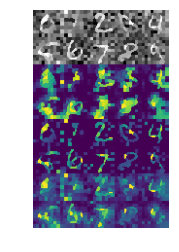

1.4000000000000001
ChebyGINLayer torch.Size([4, 20]) tensor([0.5558, 0.6940, 0.5717, 0.5774], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5724, 0.6538, 0.5261, 0.6485, 0.6058, 0.6316, 0.5916, 0.6736, 0.5344,
        0.6161], grad_fn=<SliceBackward>)
p values [ 1.4713448  -0.64743865  0.14542371 -0.23098224]
cos_sim -0.4011249840259552
ChebyGINLayer torch.Size([512, 256]) tensor([0.5708, 0.5809, 0.5748, 0.5724, 0.5660, 0.5783, 0.5556, 0.5993, 0.5665,
        0.5814], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([4, 20]) tensor([0.6902, 0.6714, 0.4736, 0.7063], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5706, 0.6627, 0.6216, 0.5825, 0.5702, 0.5336, 0.5469, 0.5189, 0.6497,
        0.6089], grad_fn=<SliceBackward>)
p values [ 0.4469076  -0.03655154 -0.12654813 -0.07055774]
cos_sim -0.07845108211040497
ChebyGINLayer torch.Size([512, 256]) tensor([0.5825, 0.5899, 0.5911, 0.5776, 0.5501, 0.5870, 0.5710, 0.5606, 0.5910,
        0.6033],

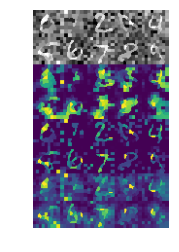

In [23]:
img_input, attn = [], []
for noise_std in np.arange(0, 1.41, 0.2):
    print(noise_std)
    noise_levels = [noise_std, 0.6]
    pred, pred_noise, pred_colornoise, alpha, alpha_noise, alpha_colornoise = get_predictions('%s/checkpoint_mnist-75sp_065802_epoch30_seed0000111.pth.tar' % checkpoints_dir,
                                                                                         noise_levels)
    _, _, _, alpha_unsup, alpha_noise_unsup, alpha_colornoise_unsup = get_predictions('%s/checkpoint_mnist-75sp_330394_epoch30_seed0000111.pth.tar' % checkpoints_dir,
                                                                                      noise_levels)
    
    _, _, _, alpha_sup, alpha_noise_sup, alpha_colornoise_sup = get_predictions('%s/checkpoint_mnist-75sp_139255_epoch30_seed0000111.pth.tar' % checkpoints_dir,
                                                                                      noise_levels)        
    img1 = visualize(alpha, alpha_noise, alpha_colornoise,
                     alpha_unsup, alpha_noise_unsup, alpha_colornoise_unsup, 
                     alpha_noise_sup,
                     noise_levels)
    img_input.append(img1)
    
    #visualize(alpha, alpha_noise, alpha_colornoise)
#     attn.append(img2)

In [24]:
imageio.mimsave('../data/mnist_animation2.gif', img_input, format='GIF', duration=1.5)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
